In [ ]:
from google.colab import drive

drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
cd /content/drive/MyDrive

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

In [ ]:
import zipfile
with zipfile.ZipFile("annotations_trainval2014.zip","r") as zip_ref:
    zip_ref.extractall("annotation") #annotation is the name of the folder to which the extrcated files should store

In [ ]:
from pycocotools.coco import COCO
import requests

# instantiate COCO specifying the annotations json path
coco = COCO('annotation/annotations/instances_train2014.json')
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['bicycle'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)
for im in images[0:1000]:
    img_data = requests.get(im['coco_url']).content
    with open('bicycle/' + im['file_name'], 'wb') as handler:
        handler.write(img_data)

loading annotations into memory...
Done (t=16.29s)
creating index...
index created!


In [ ]:
from pycocotools.coco import COCO
import requests

# instantiate COCO specifying the annotations json path
coco = COCO('annotation/annotations/instances_train2014.json')
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['person'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)
for im in images[0:1000]:
    img_data = requests.get(im['coco_url']).content
    with open('person/' + im['file_name'], 'wb') as handler:
        handler.write(img_data)

loading annotations into memory...
Done (t=13.65s)
creating index...
index created!


In [ ]:
len(images)

45174

In [ ]:
#get the annotation for a single image FOR CATID 1 (person)
annotation_ids = coco.getAnnIds(imgIds=imgIds[0], catIds=[1])

In [ ]:
len(annotation_ids)#one image has 14 anootations

14

In [ ]:
#put the annotation to list
from pycocotools.coco import COCO
coco = COCO('annotation/annotations/instances_train2014.json')
anns = coco.loadAnns(annotation_ids)

loading annotations into memory...
Done (t=14.35s)
creating index...
index created!


In [ ]:
for ann in anns:
    print(ann['bbox'])

[387.0, 71.1, 145.0, 322.0]
[494.31, 91.04, 11.7, 16.16]
[282.37, 86.79, 32.16, 97.02]
[526.17, 44.14, 90.5, 188.0]
[491.51, 81.19, 40.46, 85.34]
[477.88, 87.8, 13.7, 33.4]
[308.98, 76.76, 49.89, 148.73]
[71.97, 104.59, 59.49, 144.89]
[352.59, 136.15, 28.15, 30.84]
[52.18, 98.34, 21.89, 33.75]
[40.18, 94.65, 13.95, 22.55]
[3.3, 121.27, 83.24, 124.52]
[153.18, 61.92, 106.78, 117.82]
[26, 64, 613, 126]


In [ ]:
from pycocotools.coco import COCO
import requests
import cv2
# instantiate COCO specifying the annotations json path
coco = COCO('annotation/annotations/instances_train2014.json')
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['person'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)

loading annotations into memory...
Done (t=15.04s)
creating index...
index created!


In [ ]:
catIds = coco.getCatIds(catNms=['bicycle'])

In [ ]:
annotation_ids = coco.getAnnIds(imgIds=imgIds[0], catIds=[1])
anns = coco.loadAnns(annotation_ids)

In [ ]:
    for ann in anns:
      print((ann['bbox']))

[492.59, 278.31, 72.07, 132.27]
[577.67, 253.88, 38.2, 22.06]


In [ ]:
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(Yolo_Reshape, self).__init__()
    self.target_shape = tuple(target_shape)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    # grids 7x7

    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 2
    # no of bounding boxes per grid
    B = 1

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B

    # class probabilities

    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))

    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))

    confs = K.sigmoid(confs)

    # boxes
    print(input[:, idx2:].shape)
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    print(boxes.shape)
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])

    return outputs

In [ ]:

from pycocotools.coco import COCO
import requests
import cv2
coco = COCO('annotation/annotations/instances_train2014.json')
# Specify a list of category names of interest
pathname=['0','person/','bicycle/']

xtrain=[]
ytrain=[]
for i in range(1,3):
# Get the corresponding image ids and images using loadImgs
  imgIds = coco.getImgIds(catIds=i)

  images = coco.loadImgs(imgIds)

  m=0;
  for im in images[0:391]:
    im_path=pathname[i] + im['file_name']
    print(m)
    imn=cv2.imread(im_path)
    imn = cv.resize(imn, (448, 448))
    imn=imn/255
    imn=imn.astype(np.float16)
    xtrain.append(imn)
    m=m+1
    annotation_ids = coco.getAnnIds(imgIds=int(im['file_name'].split('_')[2].split('.')[0][6:12]), catIds=[i])
    anns = coco.loadAnns(annotation_ids)
    for ann in anns[0:1]:
      anno=[ann['bbox'][0],ann['bbox'][1],ann['bbox'][2],ann['bbox'][3],int(ann['category_id'])]
      ytrain.append(anno)



In [ ]:
import numpy as np


xtrain=np.array(xtrain)

ytrain=np.array(ytrain)


np.save('xtrain',xtrain)
np.save('ytrain',ytrain)

In [ ]:
import cv2 as cv
import numpy as np

def read(image, label):
    image = image
    #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]

    image = image / 255.

    label_matrix = np.zeros([7, 7, 7])

    xmin = label[0]
    ymin = label[1]
    xmax = label[2]
    ymax = label[3]
    cls = int(label[4])

    x = (xmin + xmax) / 2 / image_w
    y = (ymin + ymax) / 2 / image_h
    w = (xmax - xmin) / image_w
    h = (ymax - ymin) / image_h
    loc = [7 * x, 7 * y]
    loc_i = int(loc[1])
    loc_j = int(loc[0])
    y = loc[1] - loc_i
    x = loc[0] - loc_j

    if label_matrix[loc_i, loc_j, 0] == 0:
            label_matrix[loc_i, loc_j, cls] =1
            label_matrix[loc_i, loc_j, 3:7] = [x, y, w, h]
            label_matrix[loc_i, loc_j, 0] = 1  # response

    return image, label_matrix

In [ ]:

from tensorflow import keras

class My_Custom_Generator(keras.utils.Sequence) :

  def __init__(self, images, labels, batch_size) :
    self.images = images
    self.labels = labels
    self.batch_size = batch_size


  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    train_image = []
    train_label = []

    for i in range(0, len(batch_x)):
      img_path = batch_x[i]
      label = batch_y[i]
      image, label_matrix = read(img_path, label)
      train_image.append(image)
      train_label.append(label_matrix)
    return np.array(train_image), np.array(train_label)

In [ ]:
batch_size = 2000
xtrain=np.load('xtrain.npy',allow_pickle='true')
ytrain=np.load('ytrain.npy',allow_pickle='true')
print(xtrain.shape)
my_training_batch_generator = My_Custom_Generator(xtrain, ytrain, batch_size)

# my_validation_batch_generator = My_Custom_Generator(X_val, Y_val, batch_size)

xtrain, ytrain = my_training_batch_generator.__getitem__(0)
# x_val, y_val = my_training_batch_generator.__getitem__(0)
print(xtrain.shape)
print(ytrain.shape)

#print(x_val.shape)
#print(y_val.shape)

(782, 448, 448, 3)
(782, 448, 448, 3)
(782, 7, 7, 7)


In [ ]:

from tensorflow import keras
import keras.backend as K
import tensorflow as tf
class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(Yolo_Reshape, self).__init__()
    self.target_shape = tuple(target_shape)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.thdf5arget_shape
    })
    return config

  def call(self, input):
    # grids 7x7

    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 2
    # no of bounding boxes per grid
    B = 1

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B

    # class probabilities

    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))

    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))

    confs = K.sigmoid(confs)

    # boxes
    print(input[:, idx2:].shape)
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    print(boxes.shape)
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])

    return outputs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
model.add(Conv2D(filters=32, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=64, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=64, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=128, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense(512))
#model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(343, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,7)))
model.summary()


(None, 196)
(None, 7, 7, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      4160      
                                                                 
 conv2d_3 (Conv2D)          

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5')

In [ ]:
import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., 1:3]  # ? * 7 * 7 * 20
    label_box = y_true[..., 3:7]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 0]  # ? * 7 * 7

    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., 1:3]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 0:1]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 3:7]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 1, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)

    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 1, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)
    print(box_mask.shape)
    print(response_mask.shape)
    print(label_xy.shape)
    print(predict_xy.shape)
    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)

    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [ ]:
from tensorflow import keras

model.compile(loss=yolo_loss,optimizer='adam',metrics=['accuracy'])

In [ ]:

model.fit(xtrain,ytrain,batch_size=4, epochs =200, verbose = 1)

Epoch 1/200
(None, 196)
(None, 7, 7, 4)
(None, 7, 7, 1, 1)
(None, 7, 7, 1, 1)
(None, 7, 7, 1, 2)
(None, 7, 7, 1, 2)
(None, 196)
(None, 7, 7, 4)
(None, 7, 7, 1, 1)
(None, 7, 7, 1, 1)
(None, 7, 7, 1, 2)
(None, 7, 7, 1, 2)
196/196 [==============================] - 92s 349ms/step - loss: 26.1247 - accuracy: 0.1615
Epoch 2/200
196/196 [==============================] - 61s 313ms/step - loss: 23.4060 - accuracy: 0.1183
Epoch 3/200
196/196 [==============================] - 62s 314ms/step - loss: 21.9751 - accuracy: 0.0937
Epoch 4/200
196/196 [==============================] - 61s 314ms/step - loss: 21.2444 - accuracy: 0.0855
Epoch 5/200
196/196 [==============================] - 62s 315ms/step - loss: 21.7221 - accuracy: 0.0870
Epoch 6/200
196/196 [==============================] - 62s 314ms/step - loss: 21.2738 - accuracy: 0.0821
Epoch 7/200
196/196 [==============================] - 62s 315ms/step - loss: 21.0951 - accuracy: 0.0834
Epoch 8/200
196/196 [==============================] - 62

In [ ]:
model.save('socialdistance.h5')

In [ ]:
model.load_weights('socialdistance.h5')

In [ ]:
model.predict(xtrain)

In [ ]:
tf.keras.models.load_model('socialdistance.h5')


In [ ]:
socialdistance.h5yt=np.ones([7,7,7])

(1, 196)
(1, 7, 7, 4)
1/1 [==============================] - 9s 9s/step
(1, 7, 7, 2)
(7, 7, 1, 4)
[[[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]]

  [[0. 0. 0. 0.]

-1

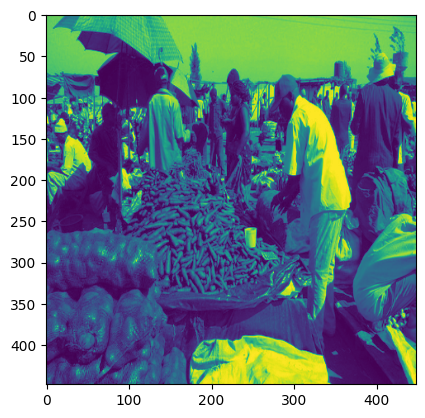

In [ ]:

    import matplotlib.pyplot as plt
    model.load_weights('/content/drive/MyDrive/socialdistance.h5', by_name=True)
    prediction = model.predict(xtrain[0:1], batch_size=1)


    predict_class = prediction[..., 1:3]  # 1 * 7 * 7 * 2
    predict_trust = prediction[..., 0:1]  # 1 * 7 * 7 * 1
    predict_box = prediction[..., 3:7]  # 1 * 7 * 7 * 4
    print(predict_class.shape)
    predict_class = np.reshape(predict_class, [7, 7, 1, 2])
    predict_trust = np.reshape(predict_trust, [7, 7, 1, 1])
    predict_box = np.reshape(predict_box, [7, 7, 1, 4])


    predict_scores = predict_class * predict_trust  # 7 * 7 * 2 * 20

    box_classes = np.argmax(predict_scores, axis=-1)  # 7 * 7 * 2
    box_class_scores = np.max(predict_scores, axis=-1)  # 7 * 7 * 2
    best_box_class_scores = np.max(box_class_scores, axis=-1, keepdims=True)  # 7 * 7 * 1

    box_mask = box_class_scores >= best_box_class_scores  # ? * 7 * 7 * 2

    filter_mask = box_class_scores >= 0.6  # 7 * 7 * 2
    filter_mask *= box_mask  # 7 * 7 * 2

    filter_mask = np.expand_dims(filter_mask, axis=-1)  # 7 * 7 * 2 * 1

    predict_scores *= filter_mask  # 7 * 7 * 2 * 20

    predict_box *= filter_mask  # 7 * 7 * 2 * 4

    box_classes = np.expand_dims(box_classes, axis=-1)
    box_classes *= filter_mask  # 7 * 7 * 2 * 1
    print(predict_box.shape)
    box_xy, box_wh = yolo_head(K.constant(predict_box))  # 7 * 7 * 2 * 2
    box_xy_min, box_xy_max = xywh2minmax(box_xy, box_wh)  # 7 * 7 * 2 * 2

    predict_trust *= filter_mask  # 7 * 7 * 2 * 1
    nms_mask = np.zeros_like(filter_mask)  # 7 * 7 * 2 * 1
    print(predict_box)
    predict_trust_max = np.max(predict_trust)  # 找到置信度最高的框
    max_i = max_j = max_k = 0
    while predict_trust_max > 0:
        for i in range(nms_mask.shape[0]):
            for j in range(nms_mask.shape[1]):
                for k in range(nms_mask.shape[2]):
                    if predict_trust[i, j, k, 0] == predict_trust_max:
                        nms_mask[i, j, k, 0] = 1
                        filter_mask[i, j, k, 0] = 0
                        max_i = i
                        max_j = j
                        max_k = k
        for i in range(nms_mask.shape[0]):
            for j in range(nms_mask.shape[1]):
                for k in range(nms_mask.shape[2]):
                    if filter_mask[i, j, k, 0] == 1:
                        iou_score = iou(box_xy_min[max_i, max_j, max_k, :],
                                        box_xy_max[max_i, max_j, max_k, :],
                                        box_xy_min[i, j, k, :],
                                        box_xy_max[i, j, k, :])
                        if iou_score > 0.2:
                            filter_mask[i, j, k, 0] = 0
        predict_trust *= filter_mask  # 7 * 7 * 2 * 1
        predict_trust_max = np.max(predict_trust)  # 找到置信度最高的框

    box_xy_min *= nms_mask
    box_xy_max *= nms_mask

    image = xtrain[0:1,:,:,0][0]
    print(image.shape)
    origin_shape = image.shape[0:2]
    #image = cv.resize(image, (448, 448))
    detect_shape = filter_mask.shape

    for i in range(detect_shape[0]):
        for j in range(detect_shape[1]):
            for k in range(detect_shape[2]):
                if nms_mask[i, j, k, 0]:
                    cv.rectangle(image, (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                                 (int(box_xy_max[i, j, k, 0]), int(box_xy_max[i, j, k, 1])),
                                 (0, 0, 255))
                    cv.putText(image, classes_name[box_classes[i, j, k, 0]],
                               (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                               1, 1, (0, 0, 255))

    #image = cv.resize(image, (origin_shape[1], origin_shape[0]))
    plt.imshow(image)
    cv.waitKey(0)